In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from pysheds.grid import Grid
import mplleaflet
%matplotlib inline

In [2]:
grid = Grid.from_raster('../Rst/20190109125130_1063922483.tif', data_name='dem')

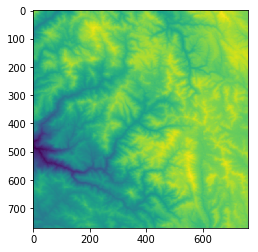

In [3]:
plt.imshow(grid.dem[:-1,:-1])

In [4]:
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent)
    plt.colorbar(label=label)
    plt.grid()

In [5]:
elevDem=grid.dem[:-1,:-1]

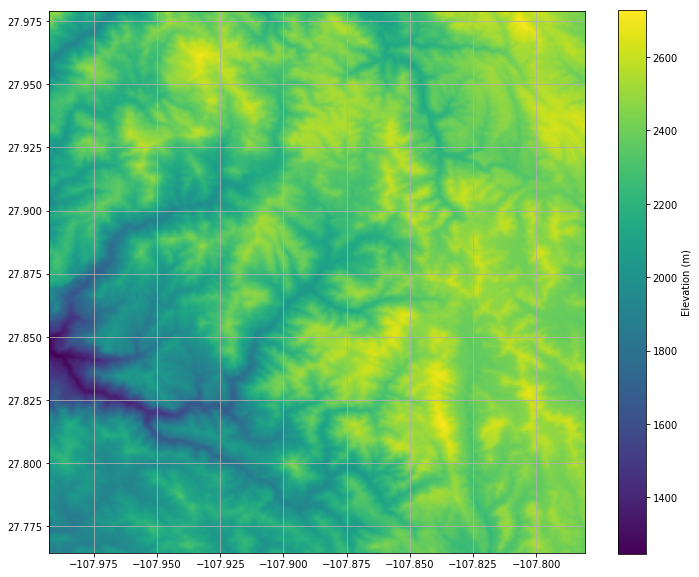

In [6]:
plotFigure(elevDem, 'Elevation (m)')

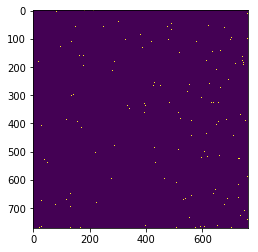

In [7]:
### Detecting depressions

# Detect depressions
depressions = grid.detect_depressions('dem')

# Plot depressions
plt.imshow(depressions)

In [1]:
# Fill depressions
grid.fill_depressions(data='dem', out_name='flooded_dem')

# Test result
depressions = grid.detect_depressions('flooded_dem')
plt.imshow(depressions)

NameError: name 'grid' is not defined

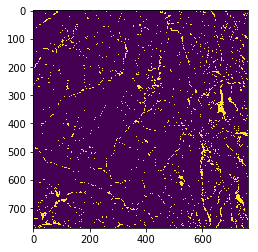

In [9]:
# Detect flats
flats = grid.detect_flats('flooded_dem')

# Plot flats
plt.imshow(flats)

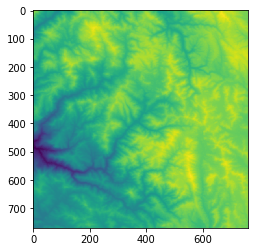

In [10]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
plt.imshow(grid.inflated_dem[:-1,:-1])

In [11]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [12]:
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

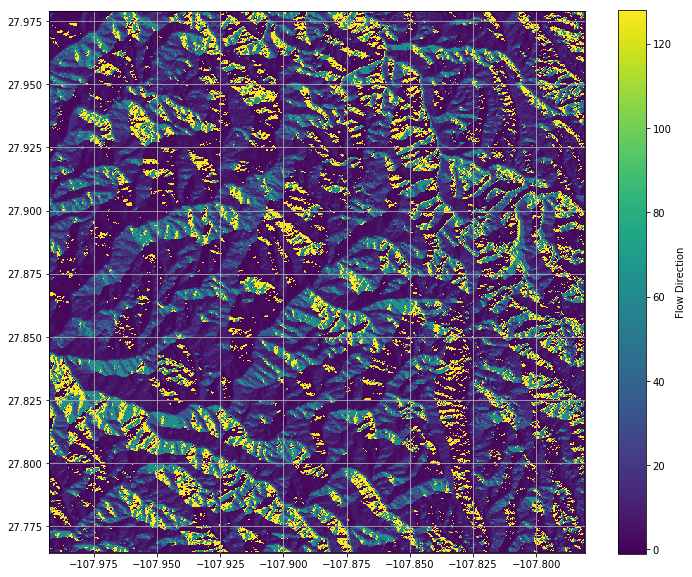

In [13]:
plotFigure(grid.dir,'Flow Direction','viridis')

In [14]:
# Specify discharge point
x, y = -107.91663,27.83479

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

In [15]:
# Clip the bounding box to the catchment
grid.clip_to('catch')

In [16]:
# Get a view of the catchment
demView = grid.view('dem', nodata=np.nan)

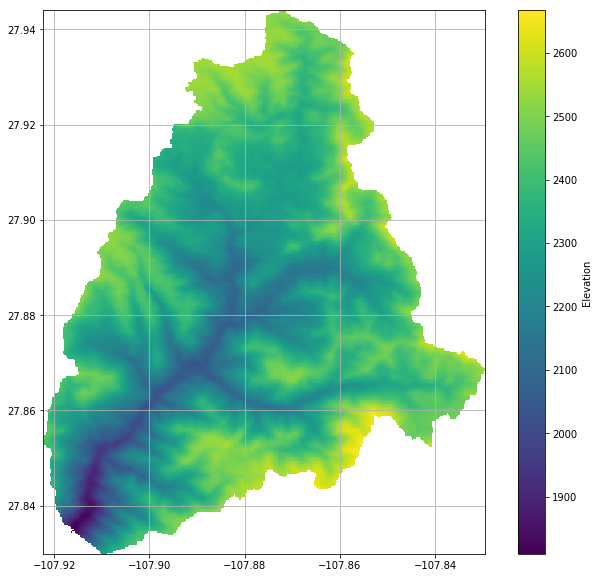

In [17]:
plotFigure(demView,'Elevation')

In [18]:
#export selected raster
grid.to_raster(demView, '../Output/clippedElevations.tif')

In [19]:
grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [2]:
accView = grid.view('acc', nodata=np.nan)
plotFigure(accView,"Cell Number",'PuRd')

NameError: name 'grid' is not defined

In [21]:
streams = grid.extract_river_network('catch', 'acc', threshold=200, dirmap=dirmap)
streams["features"][:2]

[{"geometry": {"coordinates": [[-107.86763888888879, 27.93319444444552], [-107.86763888888879, 27.933472222223298], [-107.86763888888879, 27.933750000001073], [-107.86791666666657, 27.93402777777885], [-107.86791666666657, 27.93430555555663], [-107.86791666666657, 27.93458333333441], [-107.86791666666657, 27.934861111112188], [-107.86791666666657, 27.935138888889963], [-107.86791666666657, 27.93541666666774], [-107.86791666666657, 27.93569444444552], [-107.86791666666657, 27.9359722222233], [-107.86763888888879, 27.936250000001078], [-107.86763888888879, 27.936527777778853], [-107.86736111111101, 27.93680555555663], [-107.86736111111101, 27.93708333333441], [-107.86708333333324, 27.93736111111219], [-107.86708333333324, 27.937638888889968], [-107.86708333333324, 27.937916666667743], [-107.86708333333324, 27.93819444444552], [-107.86736111111101, 27.9384722222233], [-107.86736111111101, 27.93875000000108], [-107.86763888888879, 27.939027777778858], [-107.86763888888879, 27.9393055555566

In [22]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

In [23]:
#save geojson as separate file
saveDict(streams,'../Output/streams_WGS84.geojson')

In [24]:
streamNet = gpd.read_file('../Output/streams_WGS84.geojson')
streamNet.crs = {'init' :'epsg:4326'}

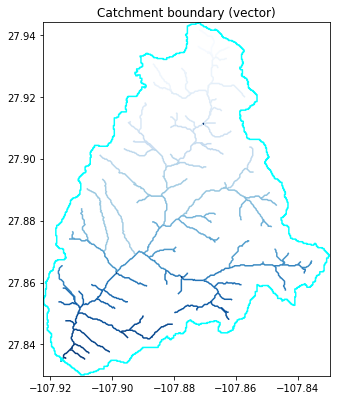

In [25]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')
    
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Catchment boundary (vector)')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

In [26]:
#ax = streamNet.plot()
mplleaflet.display(fig=ax.figure, crs=streamNet.crs, tiles='esri_aerial')